In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tqdm.auto import tqdm

/home/fetagpu/miniconda3/envs/gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2. Configuration
MODEL_NAME = "distilbert-base-uncased"          # change once if needed
DATASETS = {
    "DGA"      : "../../datasets/dga/dga_preprocessed.csv",
    "Phishing" : "../../datasets/phishing/phishing_preprocessed.csv",
    "Malware"  : "../../datasets/malware/malware_preprocessed.csv",
}
PERCENTILES = [50, 75, 90, 95, 99, 100]         # median + tails

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [4]:
# 3. Initialize tokenizer (same one you're using in training)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [5]:
# 4. Tokenize all samples and measure their lengths for the malicious domain categories
stats = {}
for name, path in DATASETS.items():
    df = pd.read_csv(path, usecols=["domain_name"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(df["domain_name"].astype(str), desc=f"Tokenising {name}", leave=False)
    ]
    lens = np.asarray(lens)

    stats[name] = {
        "mean"   : lens.mean(),
        "median" : np.median(lens),
        **{f"{p}%": np.percentile(lens, p) for p in PERCENTILES[1:]},  # skip 50 (median)
    }

table = (
    pd.DataFrame(stats)
      .reindex(["mean", "median"] + [f"{p}%" for p in PERCENTILES[1:]])
      .round(2)
)

display(table)  # nice HTML table in Jupyter


Tokenising DGA:   0%|          | 0/200000 [00:00<?, ?it/s]

,DGA,Phishing,Malware
mean,12.49,13.13,10.94
median,11.00,11.00,9.00
75%,15.00,15.00,12.00
90%,22.00,20.00,17.00
95%,25.00,28.00,22.00
99%,30.00,51.00,29.00
100%,68.00,68.00,72.00


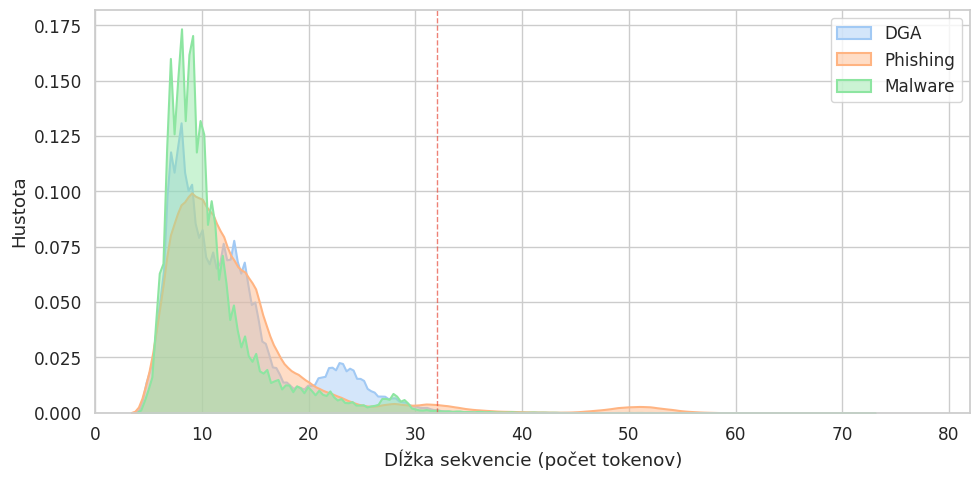

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font="DejaVu Sans", font_scale=1.1)

plt.figure(figsize=(10, 5))
palette = sns.color_palette("pastel", n_colors=len(DATASETS))

for (name, path), color in zip(DATASETS.items(), palette):
    df = pd.read_csv(path, usecols=["domain_name"])
    lens = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in df["domain_name"].astype(str)
    ]
    sns.kdeplot(
        lens,
        bw_adjust=0.8,
        fill=True,
        alpha=0.45,
        linewidth=1.5,
        label=name,
        color=color,
    )

# optional vertical guides at common truncation lengths
for x, c in zip([32], ["#E74C3C"]):
    plt.axvline(x, linestyle="--", color=c, linewidth=1, alpha=0.7)

max_len = max(table.max()) + 10
plt.xlim(0, max_len)
# plt.title("Token‑length Density Across Datasets", weight="bold")
plt.xlabel("Dĺžka sekvencie (počet tokenov)")
plt.ylabel("Hustota")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()